## EARIN6 - Szymon Gałecki
Program that distinguishes cancer versus normal patterns from mass-spectrometric data based on the dataset:  
https://archive.ics.uci.edu/ml/datasets/Arcene

In [1]:
import pip
!pip install scikit-learn
import pandas as pd

You should consider upgrading via the 'c:\users\hp\opencv\scripts\python.exe -m pip install --upgrade pip' command.


### 1. Import data set

In [2]:
td = pd.read_csv('arcene_train.data', sep='\s+',header=None)
assert td.sum().sum() == 70726744.00
assert td.isna().sum().sum() == 0
td.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0,71,0,95,0,538,404,20,0,0,...,255,570,86,0,36,0,80,0,0,524
1,0,41,82,165,60,554,379,0,71,0,...,213,605,69,7,473,0,57,0,284,423
2,0,0,1,40,0,451,402,0,0,0,...,235,593,28,0,24,0,90,0,34,508
3,0,56,44,275,14,511,470,0,0,0,...,91,600,0,26,86,0,102,0,0,469
4,105,0,141,348,0,268,329,0,0,1,...,813,0,0,0,0,190,301,0,0,354


In [3]:
tl = pd.read_csv('arcene_train.labels', header=None)
assert tl.shape[0] == td.shape[0]
assert tl.isna().sum().sum() == 0
tl.head()

,0
0,1
1,-1
2,1
3,1
4,-1


### 2. Split data set into training and testing in ratio: 80/20

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
train_d, test_d, train_l, test_l = train_test_split(td, tl, train_size=0.8, random_state=0)

In [6]:
assert train_d.shape[0] == train_l.shape[0]
assert test_d.shape[0] == test_l.shape[0]
assert train_d.shape[0] + test_d.shape[0] == td.shape[0]
assert train_l.shape[0] + test_l.shape[0] == tl.shape[0]

### 3. Import data set for validation

In [7]:
valid_d = pd.read_csv('arcene_valid.data', sep='\s+',header=None)
assert valid_d.sum().sum() == 71410108.00
assert valid_d.isna().sum().sum() == 0
#valid_d.head()

In [8]:
valid_l = pd.read_csv('arcene_valid.labels', header=None)
assert valid_l.shape[0] == valid_d.shape[0]
assert valid_l.isna().sum().sum() == 0
#valid_l.head()

### 4. Model: Linear Support Vector Classifier
Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.
This class supports both dense and sparse input and the multiclass support is handled according to a one-vs-the-rest scheme.

In [9]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, f1_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt

In [10]:
lsvc = LinearSVC(random_state=0, tol=1e-5, class_weight='balanced')
lsvc.fit(train_d, train_l.values.ravel())

LinearSVC(class_weight='balanced', random_state=0, tol=1e-05)

#### Helper functions

In [11]:
def verification(model, data, labels):
    predicted_l = model.predict(data)
    acc = accuracy_score(labels, predicted_l)
    rc = recall_score(labels, predicted_l)
    f1 = f1_score(labels, predicted_l)
    ra = roc_auc_score(labels, predicted_l)
    
    print(f'Accuracy score - {acc*100:.2f}%.')
    print(f'Recall score - {rc*100:.2f}%.')
    print(f'F1 score - {rc*100:.2f}%.')
    print(f'ROC AUC score - {rc*100:.2f}%.')

In [12]:
def confusion_matrix(model, data, labels):
    disp = plot_confusion_matrix(model, data, labels, normalize='true')
    disp.ax_.set_title('Testing: Confusion matrix - normalized')
    plt.show()

#### Verification against testing set

In [13]:
verification(lsvc, test_d, test_l)

Accuracy score - 80.00%.
Recall score - 62.50%.
F1 score - 62.50%.
ROC AUC score - 62.50%.


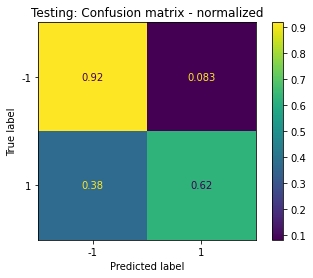

In [14]:
confusion_matrix(lsvc, test_d, test_l)

#### Verification against validation set

In [15]:
verification(lsvc, valid_d, valid_l)

Accuracy score - 86.00%.
Recall score - 75.00%.
F1 score - 75.00%.
ROC AUC score - 75.00%.


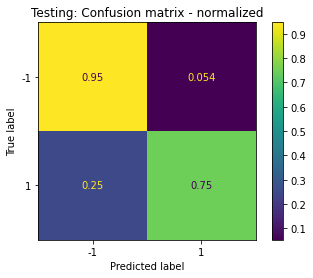

In [16]:
confusion_matrix(lsvc, valid_d, valid_l)

#### Remarks:  
- Great imbalance between false-positive and false-negative values  
- Significant percent of patients classified as negative were positive, not so good

### 5. Model: K-Nearest Neighbors
KNeighborsClassifier implements learning based on the **k** nearest neighbors of each query point, where **k** is an integer value specified by the user.

In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [18]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(train_d, train_l.values.ravel())

KNeighborsClassifier(n_neighbors=1)

#### Verification against testing set

In [19]:
verification(neigh, test_d, test_l)

Accuracy score - 65.00%.
Recall score - 62.50%.
F1 score - 62.50%.
ROC AUC score - 62.50%.


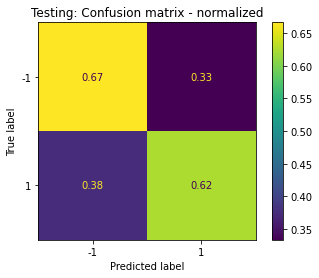

In [20]:
confusion_matrix(neigh, test_d, test_l)

#### Verification against validation set

In [21]:
verification(neigh, valid_d, valid_l)

Accuracy score - 86.00%.
Recall score - 79.55%.
F1 score - 79.55%.
ROC AUC score - 79.55%.


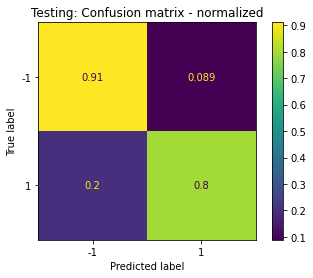

In [22]:
confusion_matrix(neigh, valid_d, valid_l)

#### Remarks:  
- Ration between false-positive and false-negative values is roughly - 1:2  
- Small percentage of false-negative classifications

### 6. Model: Random Forest
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the `max_samples` parameter if `bootstrap=True` (default), otherwise the whole dataset is used to build each tree.

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(train_d, train_l.values.ravel())

RandomForestClassifier(random_state=0)

#### Verification against testing set

In [25]:
verification(rfc, test_d, test_l)

Accuracy score - 75.00%.
Recall score - 62.50%.
F1 score - 62.50%.
ROC AUC score - 62.50%.


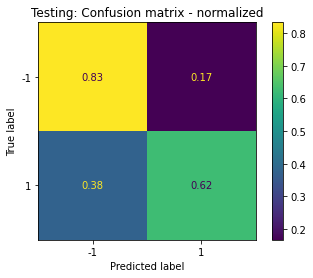

In [26]:
confusion_matrix(rfc, test_d, test_l)

#### Verification against validation set

In [27]:
verification(rfc, valid_d, valid_l)

Accuracy score - 79.00%.
Recall score - 77.27%.
F1 score - 77.27%.
ROC AUC score - 77.27%.


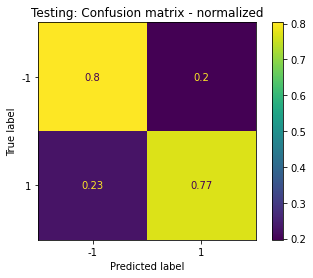

In [28]:
confusion_matrix(rfc, valid_d, valid_l)

#### Remarks:  
- Very balanced classsification

### Final remarks:
- k-nearest neighbors proved to be surprisingly good model for classification despite my assumption that it should be used mainly for data clustering
- k-nearest neighbors is most prone to overfitting, and was the least consistent model when it comes to accuracy scores
- random tree-forest was the most consistent model with linear SVC being only slightly worse in that matter
- while linear SVC was very good overall, the number of false negative values was surprisingly high
- k-nearest neighbors was the only model independent of its initialisation 